In [1]:
import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mylib

$$ \frac{d}{dx}\left(\nu\frac{du}{dx}\right) + \alpha\,u = f\qquad x\in\,(0,L)\qquad\alpha\in\mathbb{R}$$
$$ u(x) = A + B\,x + C\,x^2 + D\,x^3 $$
$$ \nu(x) = E\exp(F\sin(G\,x)) $$
$$\frac{d}{dx}\left(\nu\frac{du}{dx}\right) = EFG\cos(Gx)\exp(F\sin(Gx))(B+2Cx+3Dx^2) + E\exp(F\sin(Gx))(2C+6Dx)$$

cond(A) = 507423817.6351516
monolithic error = 0.2076019559583954
{'type': 'dirichlet', 'value': -7.0}
{'type': 'dirichlet', 'value': 70.10174618724366}


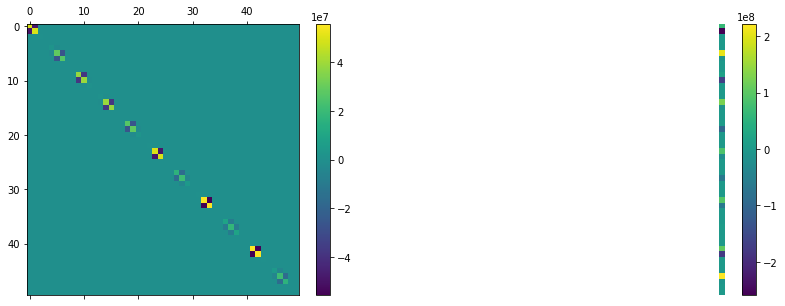

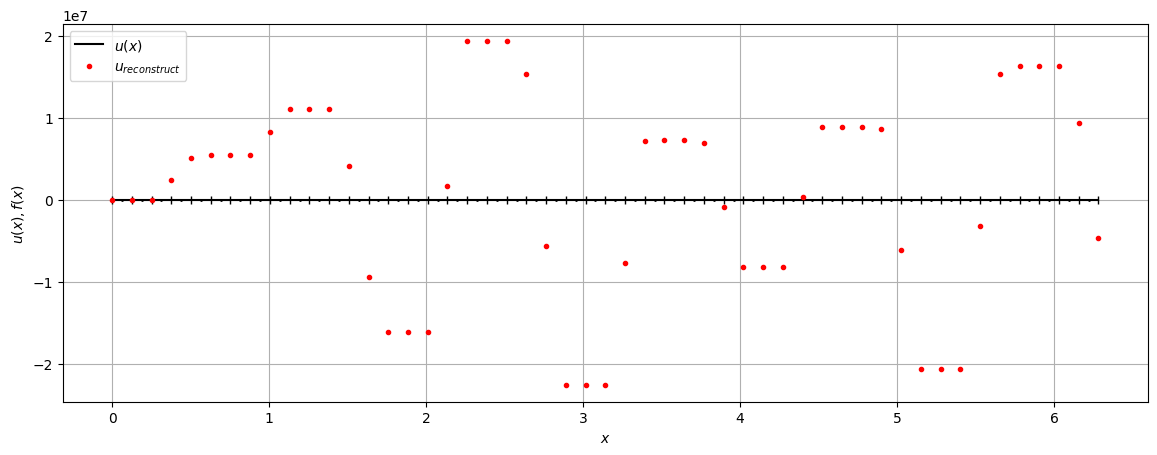

In [2]:
kwargs = {
    'A': -7.0,
    'B': 20,
    'C': -5.0,
    'D': 0.6,
    'E': 300.0,
    'F': 8.0,
    'G': 11.0,
}

L = 2*np.pi
N = 50
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

alpha = 10.0

def sol(x, kwargs):
    return kwargs['A'] + kwargs['B']*x + kwargs['C']*np.square(x) + kwargs['D']*np.power(x, 3.0)

def nu(x, kwargs):
    return kwargs['E']*np.exp(kwargs['F']*np.sin(kwargs['G']*x))

def lapl(x, kwargs):
    B = kwargs['B']
    C = kwargs['C']
    D = kwargs['D']
    E = kwargs['E']
    F = kwargs['F']
    G = kwargs['G']
    return E*F*G*np.cos(G*x)*np.exp(F*np.sin(G*x))*(B+2.0*C*x+3.0*D*np.square(x)) + E*np.exp(F*np.sin(G*x))*(2.0*C+6.0*D*x)
   
def f(x, kwargs):
    return alpha*sol(x, kwargs) + lapl(x, kwargs)
    
leftBC = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol(0.0, kwargs)}

rightBC = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol(L, kwargs)}

A1, fBC = mylib.fvm_laplacian_1D(nu, leftBC, rightBC, N, dx, L, kwargs)
A2 = alpha*sparse.eye(N)
ff = f(xc, kwargs)
fTOT = ff + fBC

A = A1+A2
A = A.toarray()

A = -np.power(dx,0.0)*A
fTOT = -np.power(dx,0.0)*fTOT

#u = sparse.linalg.spsolve(A, fTOT)
#u = u[0]
u = linalg.solve(A, fTOT)

print("cond(A) =", np.linalg.cond(A))
print(f"monolithic error = {np.linalg.norm(fTOT-np.dot(A,u))}")
print(leftBC)
print(rightBC)

fig1, axs = plt.subplots(1, 2, figsize=(14,5))
axsA = axs[0].matshow(A)
axsf = axs[1].matshow(ff.reshape((N,1)))
fig1.colorbar(axsA, ax=axs[0])
fig1.colorbar(axsf, ax=axs[1])
axs[1].axis('off')
#plt.savefig('matrix.pdf')

fig, ax = plt.subplots(figsize=(14,5), dpi=100)
markersize = 20
linewidth = 0.8
color = 'k'
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u(x), f(x)$')

ax.plot(x, 0*x, '|', color='k', markersize=6.0)
ax.plot(xc, 0*xc, '.', color='k', markersize=2.0)

ax.plot(xfine, sol(xfine, kwargs), '-k', label=r'$u(x)$')
ax.plot(x, mylib.fvm_reconstruct_1D(u), '.r' , label=r'$u_{reconstruct}$', linewidth=linewidth)
#ax.plot(xc, u, '_r', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)

#ax.plot(x, mylib.reconstruct(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax.plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax.plot(xfine, f(xfine, kwargs), '--k', label='f exact')

#ax.plot(xfine, nu(xfine, kwargs), '--k', label='nu')
ax.plot()
#ax.set_ylim(bottom=0.0)
#ax.set_xlim([-0.001,0.1])
ax.legend()
ax.grid()